In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lifelines import KaplanMeierFitter

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide
)
from multipathogen_sero.config import EXTERNAL_DATA_DIR

# Load the data

In [11]:
mordor_df = pd.read_csv(EXTERNAL_DATA_DIR / 'mordor-ab-analysis-public.csv')
mordor_df['testdate'] = pd.to_datetime(mordor_df['testdate'])
start_year = mordor_df['testdate'].min().year
mordor_df['test_month'] = 12*(mordor_df['testdate'].dt.year - start_year) + mordor_df['testdate'].dt.month

pathogen_antigen_df = mordor_df[['pathogen', 'antigen','serocut','serocut_desc']].drop_duplicates()
pathogen_antigen_df['logserocut'] = np.log10(pathogen_antigen_df['serocut'])
child_visit_df = mordor_df[['clusterid_public', 'phase', 'arm', 'childid_public', 'agem',
       'agem_start', 'agem_start_under6', 'sex', 'testdate', 'test_month', 'wet_start',
       'wet_end', 'season', 'malaria_thicksmear', 'malaria_density',
       'malaria_gameto', 'dbsid', 'type', 'well']].drop_duplicates()
sero_df = mordor_df[['childid_public', 'test_month', 'phase', 'pathogen', 'antigen',
       'antigenf', 'mfi', 'logmfi', 'seropos']]

In [18]:
seropositivity_long = sero_df[['childid_public', 'test_month', 'phase', 'antigen', 'seropos']]
seropositivity_wide = seropositivity_long.pivot_table(
    index=['childid_public', 'test_month', 'phase'],
    columns='antigen',
    values='seropos',
    aggfunc='first'
).reset_index()

# column summaries

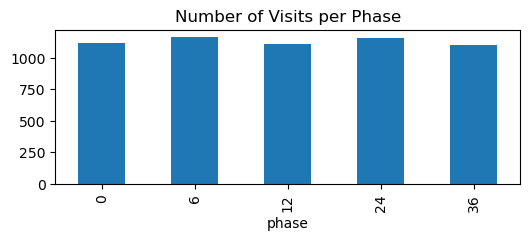

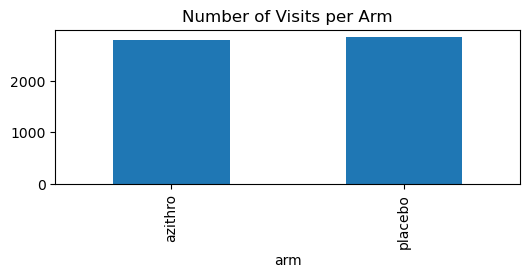

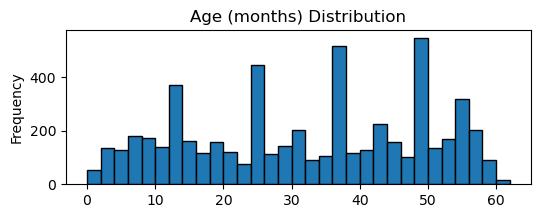

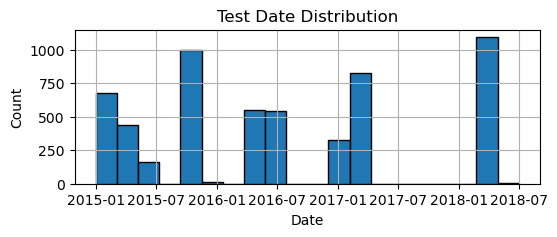

In [4]:
#plot bar chart of phase, ordering by phase
plt.figure(figsize=(6, 2))
child_visit_df['phase'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Visits per Phase')
plt.show()
#plot bar chart of arm, ordering by arm
plt.figure(figsize=(6, 2))
child_visit_df['arm'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Visits per Arm')
plt.show()
#plot histogram of age, binwidth = 2
plt.figure(figsize=(6, 2))
child_visit_df['agem'].plot(kind='hist', bins=np.arange(0, 64, 2), edgecolor='black')
plt.title('Age (months) Distribution')
plt.show()
#plot histogram of testdate, binwidth = 3 months
plt.figure(figsize=(6, 2))
child_visit_df['testdate'].dt.to_period('Q').dt.start_time.hist(bins=20, edgecolor='black')
plt.title('Test Date Distribution')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


In [63]:
pathogen_antigen_df

,pathogen,antigen,serocut,serocut_desc
0,Cryptosporidium,cp17,290.0,external
1,Cryptosporidium,cp23,945.0,external
2,Giardia,vsp3,154.0,external
3,Giardia,vsp5,147.0,external
4,Trachoma,pgp3,1613.0,external
5,Trachoma,ct694,457.0,external
6,Streptococcus,speb,884.0,presumed unexp
7,Campylobacter,p39,338.0,presumed unexp
8,Campylobacter,p18,843.0,presumed unexp
9,Salmonella,sald,10.0,presumed unexp


Serocut for pmmsp1: 431.0 (external)


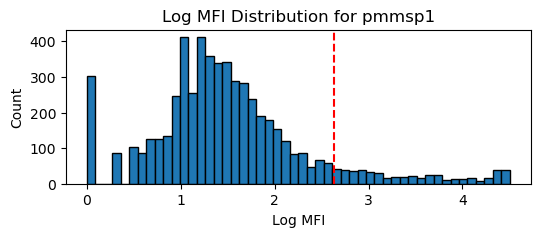

In [5]:
#### OPTIONS ####
antigen = 'pmmsp1'
#################
serocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['serocut'].values[0]
logserocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['logserocut'].values[0]
serocut_desc = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['serocut_desc'].values[0]
print(f'Serocut for {antigen}: {serocut_value} ({serocut_desc})')

# plot histogram of logmfi for a specific antigen
plt.figure(figsize=(6, 2))
sero_df[sero_df['antigen'] == antigen]['logmfi'].plot(kind='hist', bins=50, edgecolor='black')
plt.title(f'Log MFI Distribution for {antigen}')
plt.xlabel('Log MFI')
plt.ylabel('Count')
#add dashed line at serocut
plt.axvline(logserocut_value, color='red', linestyle='--', label='Serocut')
plt.show()

## Individual children

In [6]:
# Find the children with the greatest number of entries
child_entry_counts = seropositivity_wide.groupby('childid_public').size()
children_with_max_entries = child_entry_counts[child_entry_counts == 5]
print("Number of children with the greatest number of entries:", len(children_with_max_entries))

Number of children with the greatest number of entries: 34


Example child with maximum entries: child-1169
Ages (months) of tests: [41 24 24 30 56]


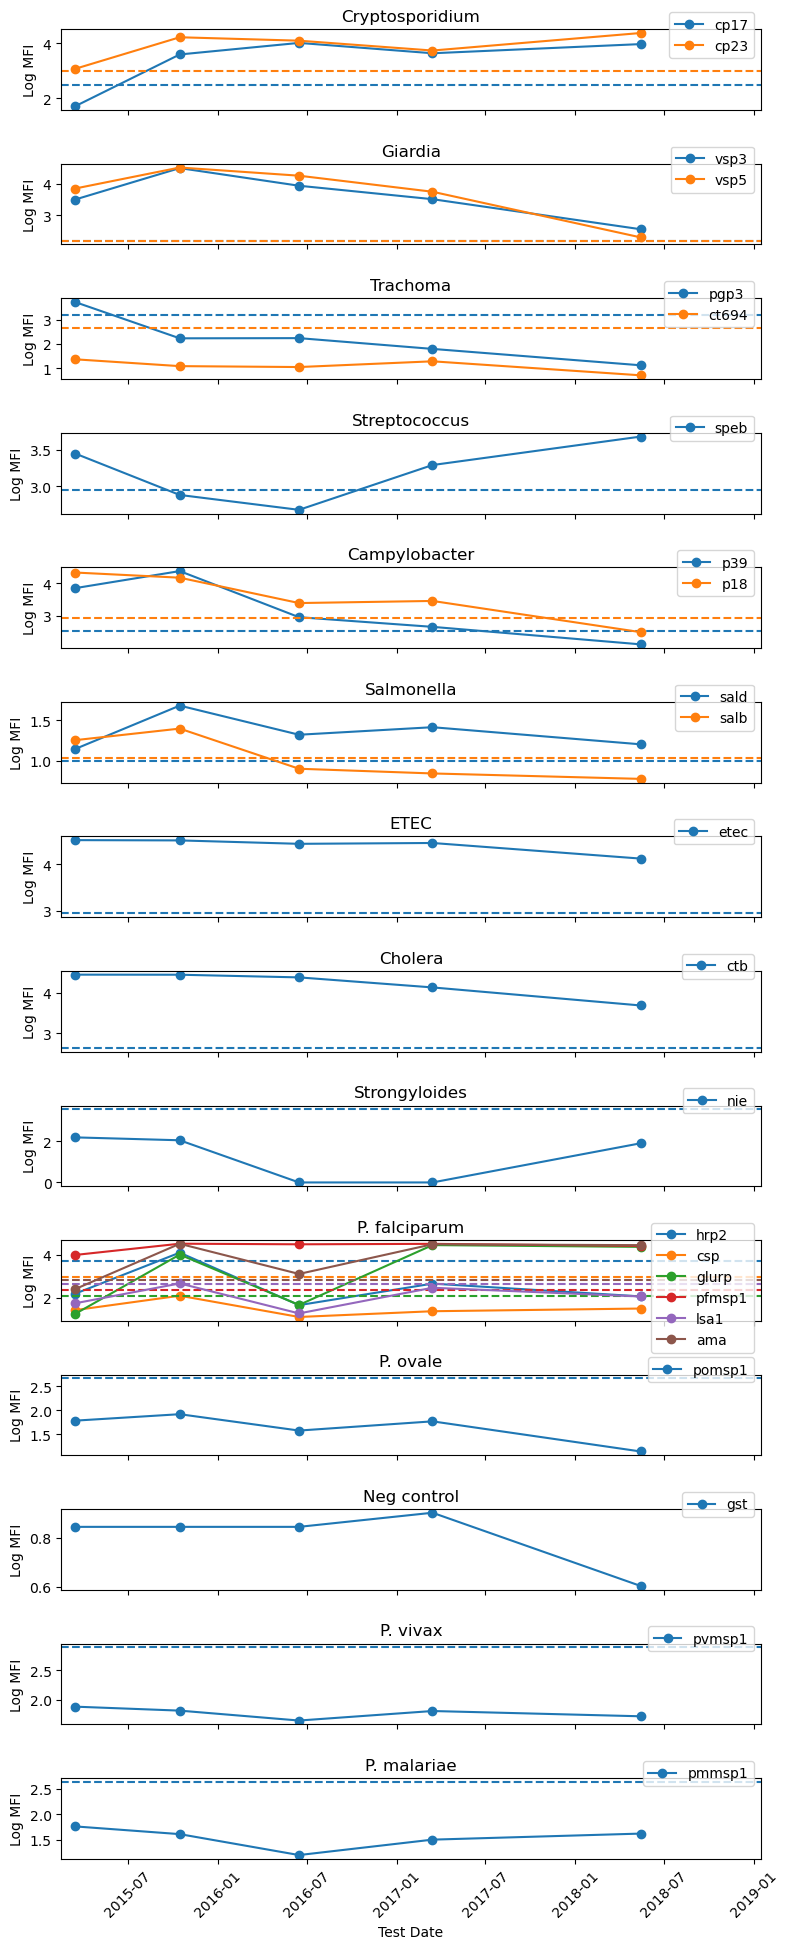

In [7]:
child_example = children_with_max_entries.index[2]
print(f'Example child with maximum entries: {child_example}')
print(f"Ages (months) of tests: {child_visit_df[child_visit_df['childid_public'] == child_example]['agem'].values}")
# Plot logmfi against testdate for each pathogen, with multiple antigens in each panel
child_sero_data = sero_df[sero_df['childid_public'] == child_example]

# Get unique pathogens
pathogens = child_sero_data['pathogen'].unique()

# Create subplots
fig, axes = plt.subplots(len(pathogens), 1, figsize=(8, 1.4 * len(pathogens)), sharex=True)  # Taller panels
for i, pathogen in enumerate(pathogens):
    pathogen_data = child_sero_data[child_sero_data['pathogen'] == pathogen]
    antigens = pathogen_data['antigen'].unique()
    for antigen in antigens:
        antigen_data = pathogen_data[pathogen_data['antigen'] == antigen].sort_values(by='testdate')
        logserocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['logserocut'].values[0]
        if not antigen_data.empty:
            # Plot logmfi line
            line, = axes[i].plot(antigen_data['testdate'], antigen_data['logmfi'], marker='o', linestyle='-', label=antigen)
            # Plot serocut line with the same color as the logmfi line
            axes[i].axhline(logserocut_value, color=line.get_color(), linestyle='--')
    # Extend x-axis by 1 year
    min_date = child_sero_data['testdate'].min() - pd.DateOffset(months=1)
    max_date = child_sero_data['testdate'].max() + pd.DateOffset(months=8)
    axes[i].set_xlim([min_date, max_date])
    # Add labels and title
    axes[i].set_ylabel('Log MFI')
    axes[i].set_title(f'{pathogen}')
    # Shift legend up by 0.3
    axes[i].legend(loc='upper right', bbox_to_anchor=(1, 1.3))
# Set common x-axis label
axes[-1].set_xlabel('Test Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Serological analysis

In [29]:
# Filter out 'gst' from antigen columns
antigen_columns = pathogen_antigen_df['antigen'].tolist()
antigen_columns = [col for col in antigen_columns if col != 'gst']

# Create lagged columns for each antigen dynamically
seropositivity_wide_with_lags = (
    seropositivity_wide
    .sort_values(by=['childid_public', 'test_month'])
    .assign(
        phase_lag=lambda df: df.groupby('childid_public')['phase'].shift(1),
        test_month_lag=lambda df: df.groupby('childid_public')['test_month'].shift(1),
        **{f"{col}_lag": lambda df, col=col: df.groupby('childid_public')[col].shift(1) for col in antigen_columns}
    )
    .groupby('childid_public')
    .tail(-1)
    .reset_index(drop=True)
)

<Figure size 800x600 with 0 Axes>

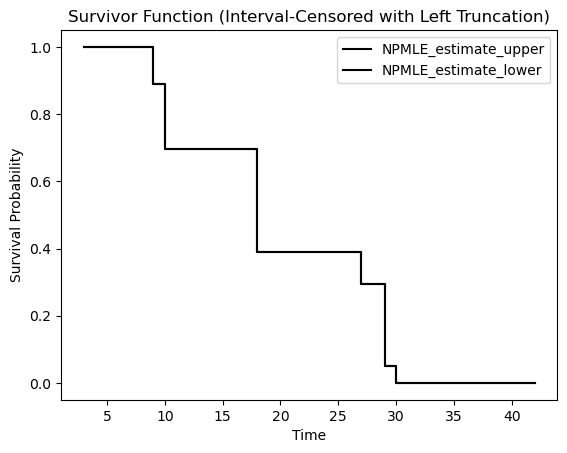

In [34]:
#### OPTIONS ####
antigen = 'ctb' # Choose an antigen to analyse e.g. 'ctb', 'pmmsp1'
#################

# Create antigen_survivor_df
antigen_survivor_df = (
    seropositivity_wide_with_lags
    .loc[seropositivity_wide_with_lags[f"{antigen}_lag"] == 0]
    .assign(
        seroconversion=lambda df: (df[antigen] == 1) & (df[f"{antigen}_lag"] == 0),
        left_trunc=lambda df: df['test_month_lag'],
        int_lower=lambda df: np.where(df['seroconversion'], df['test_month_lag'], df['test_month']),
        int_upper=lambda df: np.where(df['seroconversion'], df['test_month'], np.inf)
    )
)

# Replace np.inf with None for interval censoring
antigen_survivor_df['int_upper'] = antigen_survivor_df['int_upper'].replace(np.inf, None)

# Fit the Kaplan-Meier model for interval-censored data with left truncation
kmf = KaplanMeierFitter()
kmf.fit_interval_censoring(
    lower_bound = antigen_survivor_df['int_lower'],  # Lower bounds of interval-censored times
    upper_bound = antigen_survivor_df['int_upper']  # Upper bounds of interval
    #entry =  antigen_survivor_df['left_trunc'] # Left truncation times
)

# Plot the survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function()
plt.title("Survivor Function (Interval-Censored with Left Truncation)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()